In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='500'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs/profiles-v1/profiles-v1-pca'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
INPUT_PT_PATH = f"/workspace/datasets/profiles-v1/profiles-v1-pca/profiles-v1-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v1_pca_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_500_20250721_0234


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_500_20250721_0234/density_plot.png


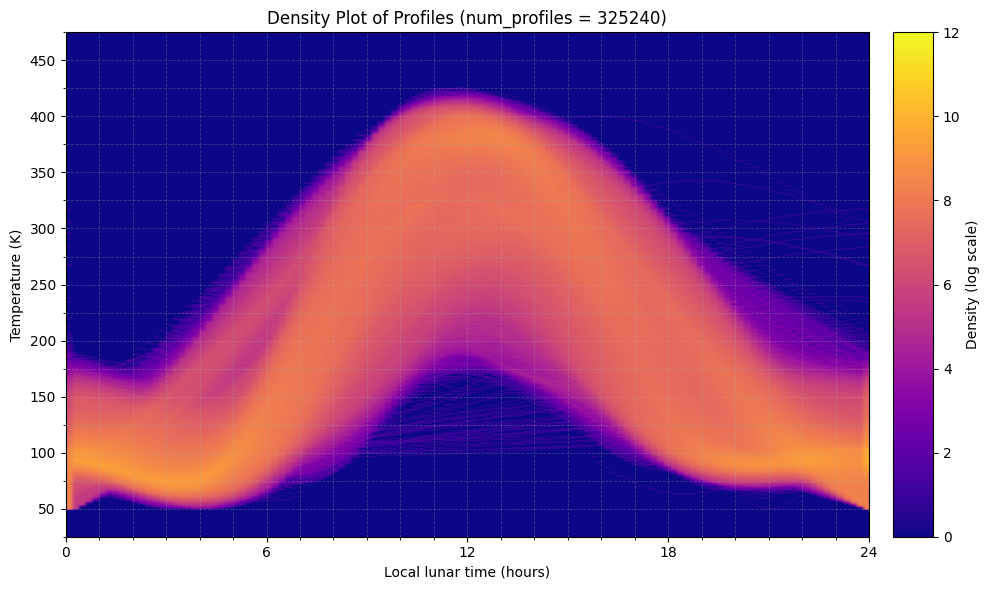

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 191.0268
STD: 99.4779
Min Temp: 50.0000
Max Temp: 424.9460
Datasets:
Training Data: 227668
Validation Data: 65048
Test Data: 32524


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.32it/s, best_loss=0.5813]


[Training] Epoch 1/100, L1 Loss: 0.5990, L2 Loss: 0.5933, KL Loss: 0.5561, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 326/326 [00:03<00:00, 99.32it/s] 


[Validation] Epoch 1/100, Val L1 Loss: 0.5245, Val L2 Loss: 0.5052, Val KL Loss: 0.6231
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_500_20250721_0234'


[Training] Epoch 2/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.08it/s, best_loss=0.5590]


[Training] Epoch 2/100, L1 Loss: 0.5659, L2 Loss: 0.5478, KL Loss: 0.6108, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 326/326 [00:03<00:00, 92.20it/s] 


[Validation] Epoch 2/100, Val L1 Loss: 0.5207, Val L2 Loss: 0.5018, Val KL Loss: 0.6182
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_500_20250721_0234'


[Training] Epoch 3/100: 100%|██████████| 1139/1139 [00:42<00:00, 26.98it/s, best_loss=0.5570]


[Training] Epoch 3/100, L1 Loss: 0.5646, L2 Loss: 0.5465, KL Loss: 0.6105, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 326/326 [00:03<00:00, 96.94it/s] 


[Validation] Epoch 3/100, Val L1 Loss: 0.5201, Val L2 Loss: 0.5014, Val KL Loss: 0.6161
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_500_20250721_0234'


[Training] Epoch 4/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.92it/s, best_loss=0.5507]


[Training] Epoch 4/100, L1 Loss: 0.5646, L2 Loss: 0.5462, KL Loss: 0.6093, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 326/326 [00:03<00:00, 99.55it/s] 


[Validation] Epoch 4/100, Val L1 Loss: 0.5231, Val L2 Loss: 0.5035, Val KL Loss: 0.6069


[Training] Epoch 5/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.64it/s, best_loss=0.5717]


[Training] Epoch 5/100, L1 Loss: 0.5648, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 326/326 [00:03<00:00, 98.78it/s] 


[Validation] Epoch 5/100, Val L1 Loss: 0.5210, Val L2 Loss: 0.5019, Val KL Loss: 0.6114


[Training] Epoch 6/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.36it/s, best_loss=0.5782]


[Training] Epoch 6/100, L1 Loss: 0.5648, L2 Loss: 0.5465, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 326/326 [00:03<00:00, 98.48it/s] 


[Validation] Epoch 6/100, Val L1 Loss: 0.5205, Val L2 Loss: 0.5015, Val KL Loss: 0.6132


[Training] Epoch 7/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.49it/s, best_loss=0.5553]


[Training] Epoch 7/100, L1 Loss: 0.5647, L2 Loss: 0.5465, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 326/326 [00:03<00:00, 102.28it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5197, Val L2 Loss: 0.5010, Val KL Loss: 0.6174
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_500_20250721_0234'


[Training] Epoch 8/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.41it/s, best_loss=0.5640]


[Training] Epoch 8/100, L1 Loss: 0.5648, L2 Loss: 0.5466, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 326/326 [00:03<00:00, 98.20it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5247, Val L2 Loss: 0.5046, Val KL Loss: 0.6038


[Training] Epoch 9/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.49it/s, best_loss=0.5660]


[Training] Epoch 9/100, L1 Loss: 0.5647, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 326/326 [00:03<00:00, 94.09it/s] 


[Validation] Epoch 9/100, Val L1 Loss: 0.5205, Val L2 Loss: 0.5016, Val KL Loss: 0.6154


[Training] Epoch 10/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.99it/s, best_loss=0.5790]


[Training] Epoch 10/100, L1 Loss: 0.5645, L2 Loss: 0.5460, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 326/326 [00:03<00:00, 98.11it/s] 


[Validation] Epoch 10/100, Val L1 Loss: 0.5218, Val L2 Loss: 0.5027, Val KL Loss: 0.6126


[Training] Epoch 11/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.10it/s, best_loss=0.5547]


[Training] Epoch 11/100, L1 Loss: 0.5646, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 326/326 [00:03<00:00, 97.45it/s] 


[Validation] Epoch 11/100, Val L1 Loss: 0.5221, Val L2 Loss: 0.5030, Val KL Loss: 0.6115


[Training] Epoch 12/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.16it/s, best_loss=0.5630]


[Training] Epoch 12/100, L1 Loss: 0.5648, L2 Loss: 0.5465, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 326/326 [00:03<00:00, 99.20it/s] 


[Validation] Epoch 12/100, Val L1 Loss: 0.5261, Val L2 Loss: 0.5060, Val KL Loss: 0.6012


[Training] Epoch 13/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.94it/s, best_loss=0.5769]


[Training] Epoch 13/100, L1 Loss: 0.5646, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 326/326 [00:03<00:00, 99.39it/s] 


[Validation] Epoch 13/100, Val L1 Loss: 0.5219, Val L2 Loss: 0.5029, Val KL Loss: 0.6102


[Training] Epoch 14/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.36it/s, best_loss=0.5726]


[Training] Epoch 14/100, L1 Loss: 0.5646, L2 Loss: 0.5463, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 326/326 [00:03<00:00, 100.32it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5240, Val L2 Loss: 0.5042, Val KL Loss: 0.6124


[Training] Epoch 15/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.69it/s, best_loss=0.5768]


[Training] Epoch 15/100, L1 Loss: 0.5647, L2 Loss: 0.5464, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 326/326 [00:03<00:00, 99.49it/s] 


[Validation] Epoch 15/100, Val L1 Loss: 0.5192, Val L2 Loss: 0.5006, Val KL Loss: 0.6189
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_500_20250721_0234'


[Training] Epoch 16/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.55it/s, best_loss=0.5742]


[Training] Epoch 16/100, L1 Loss: 0.5648, L2 Loss: 0.5465, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 326/326 [00:03<00:00, 103.48it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5235, Val L2 Loss: 0.5042, Val KL Loss: 0.6089


[Training] Epoch 17/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.91it/s, best_loss=0.5665]


[Training] Epoch 17/100, L1 Loss: 0.5643, L2 Loss: 0.5458, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 326/326 [00:03<00:00, 102.38it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5230, Val L2 Loss: 0.5036, Val KL Loss: 0.6066


[Training] Epoch 18/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.65it/s, best_loss=0.5648]


[Training] Epoch 18/100, L1 Loss: 0.5648, L2 Loss: 0.5464, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 326/326 [00:03<00:00, 100.68it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5223, Val L2 Loss: 0.5031, Val KL Loss: 0.6111


[Training] Epoch 19/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.51it/s, best_loss=0.5597]


[Training] Epoch 19/100, L1 Loss: 0.5648, L2 Loss: 0.5465, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 326/326 [00:03<00:00, 100.74it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5219, Val L2 Loss: 0.5028, Val KL Loss: 0.6078


[Training] Epoch 20/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.32it/s, best_loss=0.5776]


[Training] Epoch 20/100, L1 Loss: 0.5647, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 326/326 [00:03<00:00, 97.59it/s] 


[Validation] Epoch 20/100, Val L1 Loss: 0.5238, Val L2 Loss: 0.5041, Val KL Loss: 0.6076


[Training] Epoch 21/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.46it/s, best_loss=0.5677]


[Training] Epoch 21/100, L1 Loss: 0.5649, L2 Loss: 0.5466, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 326/326 [00:03<00:00, 101.68it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5222, Val L2 Loss: 0.5030, Val KL Loss: 0.6122


[Training] Epoch 22/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.43it/s, best_loss=0.5656]


[Training] Epoch 22/100, L1 Loss: 0.5648, L2 Loss: 0.5466, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 326/326 [00:03<00:00, 98.32it/s] 


[Validation] Epoch 22/100, Val L1 Loss: 0.5245, Val L2 Loss: 0.5048, Val KL Loss: 0.6040


[Training] Epoch 23/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.64it/s, best_loss=0.5702]


[Training] Epoch 23/100, L1 Loss: 0.5647, L2 Loss: 0.5463, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 326/326 [00:03<00:00, 98.13it/s] 


[Validation] Epoch 23/100, Val L1 Loss: 0.5255, Val L2 Loss: 0.5055, Val KL Loss: 0.6024


[Training] Epoch 24/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.29it/s, best_loss=0.5581]


[Training] Epoch 24/100, L1 Loss: 0.5648, L2 Loss: 0.5465, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 326/326 [00:03<00:00, 101.48it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5213, Val L2 Loss: 0.5023, Val KL Loss: 0.6128


[Training] Epoch 25/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.00it/s, best_loss=0.5667]


[Training] Epoch 25/100, L1 Loss: 0.5647, L2 Loss: 0.5464, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 326/326 [00:03<00:00, 100.89it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5200, Val L2 Loss: 0.5012, Val KL Loss: 0.6132


[Training] Epoch 26/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.39it/s, best_loss=0.5591]


[Training] Epoch 26/100, L1 Loss: 0.5649, L2 Loss: 0.5467, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 326/326 [00:03<00:00, 106.53it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5227, Val L2 Loss: 0.5033, Val KL Loss: 0.6116


[Training] Epoch 27/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.55it/s, best_loss=0.5554]


[Training] Epoch 27/100, L1 Loss: 0.5646, L2 Loss: 0.5464, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 326/326 [00:03<00:00, 99.18it/s] 


[Validation] Epoch 27/100, Val L1 Loss: 0.5222, Val L2 Loss: 0.5033, Val KL Loss: 0.6092


[Training] Epoch 28/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.20it/s, best_loss=0.5735]


[Training] Epoch 28/100, L1 Loss: 0.5650, L2 Loss: 0.5467, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 326/326 [00:03<00:00, 100.98it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5214, Val L2 Loss: 0.5023, Val KL Loss: 0.6100


[Training] Epoch 29/100: 100%|██████████| 1139/1139 [00:41<00:00, 27.77it/s, best_loss=0.5652]


[Training] Epoch 29/100, L1 Loss: 0.5648, L2 Loss: 0.5466, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 326/326 [00:03<00:00, 94.52it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5223, Val L2 Loss: 0.5032, Val KL Loss: 0.6092


[Training] Epoch 30/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.85it/s, best_loss=0.5746]


[Training] Epoch 30/100, L1 Loss: 0.5648, L2 Loss: 0.5465, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 326/326 [00:03<00:00, 95.19it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5214, Val L2 Loss: 0.5023, Val KL Loss: 0.6190


[Training] Epoch 31/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.99it/s, best_loss=0.5771]


[Training] Epoch 31/100, L1 Loss: 0.5648, L2 Loss: 0.5465, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 326/326 [00:03<00:00, 95.55it/s] 


[Validation] Epoch 31/100, Val L1 Loss: 0.5189, Val L2 Loss: 0.5005, Val KL Loss: 0.6201
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_500_20250721_0234'


[Training] Epoch 32/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.10it/s, best_loss=0.5665]


[Training] Epoch 32/100, L1 Loss: 0.5647, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 326/326 [00:03<00:00, 98.83it/s] 


[Validation] Epoch 32/100, Val L1 Loss: 0.5199, Val L2 Loss: 0.5012, Val KL Loss: 0.6234


[Training] Epoch 33/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.62it/s, best_loss=0.5421]


[Training] Epoch 33/100, L1 Loss: 0.5645, L2 Loss: 0.5461, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 326/326 [00:03<00:00, 93.42it/s] 


[Validation] Epoch 33/100, Val L1 Loss: 0.5224, Val L2 Loss: 0.5031, Val KL Loss: 0.6106


[Training] Epoch 34/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.81it/s, best_loss=0.5701]


[Training] Epoch 34/100, L1 Loss: 0.5649, L2 Loss: 0.5465, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 326/326 [00:03<00:00, 102.58it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5232, Val L2 Loss: 0.5039, Val KL Loss: 0.6090


[Training] Epoch 35/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.21it/s, best_loss=0.5692]


[Training] Epoch 35/100, L1 Loss: 0.5645, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 326/326 [00:03<00:00, 103.31it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5213, Val L2 Loss: 0.5022, Val KL Loss: 0.6104


[Training] Epoch 36/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.51it/s, best_loss=0.5715]


[Training] Epoch 36/100, L1 Loss: 0.5645, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 326/326 [00:03<00:00, 101.76it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5219, Val L2 Loss: 0.5028, Val KL Loss: 0.6095


[Training] Epoch 37/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.27it/s, best_loss=0.5688]


[Training] Epoch 37/100, L1 Loss: 0.5645, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 326/326 [00:03<00:00, 104.61it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5191, Val L2 Loss: 0.5005, Val KL Loss: 0.6161


[Training] Epoch 38/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.64it/s, best_loss=0.5794]


[Training] Epoch 38/100, L1 Loss: 0.5645, L2 Loss: 0.5461, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 326/326 [00:03<00:00, 100.37it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5231, Val L2 Loss: 0.5036, Val KL Loss: 0.6073


[Training] Epoch 39/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.14it/s, best_loss=0.5636]


[Training] Epoch 39/100, L1 Loss: 0.5649, L2 Loss: 0.5466, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 326/326 [00:03<00:00, 99.99it/s] 


[Validation] Epoch 39/100, Val L1 Loss: 0.5249, Val L2 Loss: 0.5049, Val KL Loss: 0.6021


[Training] Epoch 40/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.35it/s, best_loss=0.5826]


[Training] Epoch 40/100, L1 Loss: 0.5649, L2 Loss: 0.5465, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 326/326 [00:03<00:00, 98.96it/s] 


[Validation] Epoch 40/100, Val L1 Loss: 0.5213, Val L2 Loss: 0.5023, Val KL Loss: 0.6081


[Training] Epoch 41/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.57it/s, best_loss=0.5760]


[Training] Epoch 41/100, L1 Loss: 0.5647, L2 Loss: 0.5462, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 326/326 [00:03<00:00, 104.44it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5244, Val L2 Loss: 0.5047, Val KL Loss: 0.5994


[Training] Epoch 42/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.31it/s, best_loss=0.5648]


[Training] Epoch 42/100, L1 Loss: 0.5645, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 326/326 [00:03<00:00, 104.36it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5243, Val L2 Loss: 0.5045, Val KL Loss: 0.6049


[Training] Epoch 43/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.42it/s, best_loss=0.5747]


[Training] Epoch 43/100, L1 Loss: 0.5647, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 326/326 [00:03<00:00, 102.94it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5211, Val L2 Loss: 0.5022, Val KL Loss: 0.6134


[Training] Epoch 44/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.34it/s, best_loss=0.5700]


[Training] Epoch 44/100, L1 Loss: 0.5648, L2 Loss: 0.5466, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 326/326 [00:03<00:00, 100.65it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5171, Val L2 Loss: 0.4992, Val KL Loss: 0.6270
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca/profiles_v1_pca_500_20250721_0234'


[Training] Epoch 45/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.82it/s, best_loss=0.5564]


[Training] Epoch 45/100, L1 Loss: 0.5646, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 326/326 [00:03<00:00, 101.30it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5202, Val L2 Loss: 0.5013, Val KL Loss: 0.6221


[Training] Epoch 46/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.97it/s, best_loss=0.5866]


[Training] Epoch 46/100, L1 Loss: 0.5646, L2 Loss: 0.5462, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 326/326 [00:03<00:00, 99.88it/s] 


[Validation] Epoch 46/100, Val L1 Loss: 0.5212, Val L2 Loss: 0.5021, Val KL Loss: 0.6079


[Training] Epoch 47/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.36it/s, best_loss=0.5794]


[Training] Epoch 47/100, L1 Loss: 0.5648, L2 Loss: 0.5466, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 326/326 [00:03<00:00, 98.77it/s] 


[Validation] Epoch 47/100, Val L1 Loss: 0.5251, Val L2 Loss: 0.5053, Val KL Loss: 0.6029


[Training] Epoch 48/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.27it/s, best_loss=0.5693]


[Training] Epoch 48/100, L1 Loss: 0.5643, L2 Loss: 0.5459, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 326/326 [00:03<00:00, 96.64it/s] 


[Validation] Epoch 48/100, Val L1 Loss: 0.5208, Val L2 Loss: 0.5021, Val KL Loss: 0.6137


[Training] Epoch 49/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.15it/s, best_loss=0.5700]


[Training] Epoch 49/100, L1 Loss: 0.5648, L2 Loss: 0.5462, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 326/326 [00:03<00:00, 100.45it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5199, Val L2 Loss: 0.5013, Val KL Loss: 0.6144


[Training] Epoch 50/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.15it/s, best_loss=0.5585]


[Training] Epoch 50/100, L1 Loss: 0.5646, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 326/326 [00:03<00:00, 99.82it/s] 


[Validation] Epoch 50/100, Val L1 Loss: 0.5223, Val L2 Loss: 0.5031, Val KL Loss: 0.6063


[Training] Epoch 51/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.60it/s, best_loss=0.5553]


[Training] Epoch 51/100, L1 Loss: 0.5649, L2 Loss: 0.5466, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 326/326 [00:03<00:00, 99.77it/s] 


[Validation] Epoch 51/100, Val L1 Loss: 0.5250, Val L2 Loss: 0.5051, Val KL Loss: 0.6020


[Training] Epoch 52/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.58it/s, best_loss=0.5649]


[Training] Epoch 52/100, L1 Loss: 0.5647, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 326/326 [00:03<00:00, 99.75it/s] 


[Validation] Epoch 52/100, Val L1 Loss: 0.5293, Val L2 Loss: 0.5086, Val KL Loss: 0.5924


[Training] Epoch 53/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.61it/s, best_loss=0.5592]


[Training] Epoch 53/100, L1 Loss: 0.5650, L2 Loss: 0.5468, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 326/326 [00:03<00:00, 99.49it/s] 


[Validation] Epoch 53/100, Val L1 Loss: 0.5274, Val L2 Loss: 0.5072, Val KL Loss: 0.5959


[Training] Epoch 54/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.41it/s, best_loss=0.5644]


[Training] Epoch 54/100, L1 Loss: 0.5648, L2 Loss: 0.5465, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 326/326 [00:03<00:00, 101.52it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5230, Val L2 Loss: 0.5036, Val KL Loss: 0.6086


[Training] Epoch 55/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.73it/s, best_loss=0.5772]


[Training] Epoch 55/100, L1 Loss: 0.5646, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 326/326 [00:03<00:00, 103.04it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5221, Val L2 Loss: 0.5030, Val KL Loss: 0.6112


[Training] Epoch 56/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.41it/s, best_loss=0.5523]


[Training] Epoch 56/100, L1 Loss: 0.5649, L2 Loss: 0.5467, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 326/326 [00:03<00:00, 100.01it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5200, Val L2 Loss: 0.5013, Val KL Loss: 0.6155


[Training] Epoch 57/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.80it/s, best_loss=0.5740]


[Training] Epoch 57/100, L1 Loss: 0.5647, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 326/326 [00:03<00:00, 97.99it/s] 


[Validation] Epoch 57/100, Val L1 Loss: 0.5222, Val L2 Loss: 0.5032, Val KL Loss: 0.6072


[Training] Epoch 58/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.43it/s, best_loss=0.5707]


[Training] Epoch 58/100, L1 Loss: 0.5648, L2 Loss: 0.5466, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 326/326 [00:03<00:00, 98.82it/s] 


[Validation] Epoch 58/100, Val L1 Loss: 0.5186, Val L2 Loss: 0.5001, Val KL Loss: 0.6187


[Training] Epoch 59/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.05it/s, best_loss=0.5616]


[Training] Epoch 59/100, L1 Loss: 0.5648, L2 Loss: 0.5466, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 326/326 [00:03<00:00, 102.23it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5203, Val L2 Loss: 0.5015, Val KL Loss: 0.6156


[Training] Epoch 60/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.67it/s, best_loss=0.5649]


[Training] Epoch 60/100, L1 Loss: 0.5648, L2 Loss: 0.5467, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 326/326 [00:03<00:00, 100.90it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5218, Val L2 Loss: 0.5025, Val KL Loss: 0.6091


[Training] Epoch 61/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.15it/s, best_loss=0.5461]


[Training] Epoch 61/100, L1 Loss: 0.5648, L2 Loss: 0.5464, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 326/326 [00:03<00:00, 99.99it/s] 


[Validation] Epoch 61/100, Val L1 Loss: 0.5248, Val L2 Loss: 0.5049, Val KL Loss: 0.6059


[Training] Epoch 62/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.23it/s, best_loss=0.5772]


[Training] Epoch 62/100, L1 Loss: 0.5645, L2 Loss: 0.5461, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 326/326 [00:03<00:00, 105.56it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5221, Val L2 Loss: 0.5029, Val KL Loss: 0.6116


[Training] Epoch 63/100: 100%|██████████| 1139/1139 [00:40<00:00, 27.96it/s, best_loss=0.5772]


[Training] Epoch 63/100, L1 Loss: 0.5648, L2 Loss: 0.5465, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 326/326 [00:03<00:00, 97.60it/s] 


[Validation] Epoch 63/100, Val L1 Loss: 0.5219, Val L2 Loss: 0.5025, Val KL Loss: 0.6100


[Training] Epoch 64/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.69it/s, best_loss=0.5746]


[Training] Epoch 64/100, L1 Loss: 0.5646, L2 Loss: 0.5463, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 326/326 [00:03<00:00, 89.15it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5227, Val L2 Loss: 0.5032, Val KL Loss: 0.6069


[Training] Epoch 65/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.59it/s, best_loss=0.5640]


[Training] Epoch 65/100, L1 Loss: 0.5647, L2 Loss: 0.5463, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 326/326 [00:03<00:00, 97.89it/s] 


[Validation] Epoch 65/100, Val L1 Loss: 0.5242, Val L2 Loss: 0.5045, Val KL Loss: 0.6024


[Training] Epoch 66/100: 100%|██████████| 1139/1139 [00:40<00:00, 27.96it/s, best_loss=0.5770]


[Training] Epoch 66/100, L1 Loss: 0.5648, L2 Loss: 0.5466, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 326/326 [00:03<00:00, 97.25it/s] 


[Validation] Epoch 66/100, Val L1 Loss: 0.5240, Val L2 Loss: 0.5042, Val KL Loss: 0.6090


[Training] Epoch 67/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.14it/s, best_loss=0.5436]


[Training] Epoch 67/100, L1 Loss: 0.5649, L2 Loss: 0.5466, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 326/326 [00:03<00:00, 101.05it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5252, Val L2 Loss: 0.5052, Val KL Loss: 0.6036


[Training] Epoch 68/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.83it/s, best_loss=0.5503]


[Training] Epoch 68/100, L1 Loss: 0.5644, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 326/326 [00:03<00:00, 102.11it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5226, Val L2 Loss: 0.5032, Val KL Loss: 0.6110


[Training] Epoch 69/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.85it/s, best_loss=0.5592]


[Training] Epoch 69/100, L1 Loss: 0.5645, L2 Loss: 0.5461, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 326/326 [00:03<00:00, 101.37it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5227, Val L2 Loss: 0.5035, Val KL Loss: 0.6089


[Training] Epoch 70/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.88it/s, best_loss=0.5533]


[Training] Epoch 70/100, L1 Loss: 0.5645, L2 Loss: 0.5461, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 326/326 [00:03<00:00, 91.62it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5224, Val L2 Loss: 0.5031, Val KL Loss: 0.6080


[Training] Epoch 71/100: 100%|██████████| 1139/1139 [00:40<00:00, 28.35it/s, best_loss=0.5640]


[Training] Epoch 71/100, L1 Loss: 0.5645, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 326/326 [00:03<00:00, 99.48it/s] 


[Validation] Epoch 71/100, Val L1 Loss: 0.5233, Val L2 Loss: 0.5039, Val KL Loss: 0.6076


[Training] Epoch 72/100: 100%|██████████| 1139/1139 [00:40<00:00, 28.43it/s, best_loss=0.5602]


[Training] Epoch 72/100, L1 Loss: 0.5648, L2 Loss: 0.5464, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 326/326 [00:03<00:00, 97.36it/s] 


[Validation] Epoch 72/100, Val L1 Loss: 0.5254, Val L2 Loss: 0.5055, Val KL Loss: 0.6003


[Training] Epoch 73/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.73it/s, best_loss=0.5717]


[Training] Epoch 73/100, L1 Loss: 0.5649, L2 Loss: 0.5467, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 326/326 [00:03<00:00, 96.21it/s] 


[Validation] Epoch 73/100, Val L1 Loss: 0.5227, Val L2 Loss: 0.5033, Val KL Loss: 0.6085


[Training] Epoch 74/100: 100%|██████████| 1139/1139 [00:40<00:00, 27.98it/s, best_loss=0.5705]


[Training] Epoch 74/100, L1 Loss: 0.5646, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 326/326 [00:03<00:00, 96.36it/s] 


[Validation] Epoch 74/100, Val L1 Loss: 0.5200, Val L2 Loss: 0.5013, Val KL Loss: 0.6152


[Training] Epoch 75/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.65it/s, best_loss=0.5636]


[Training] Epoch 75/100, L1 Loss: 0.5645, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 326/326 [00:03<00:00, 100.46it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5220, Val L2 Loss: 0.5029, Val KL Loss: 0.6116


[Training] Epoch 76/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.02it/s, best_loss=0.5650]


[Training] Epoch 76/100, L1 Loss: 0.5646, L2 Loss: 0.5462, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 326/326 [00:03<00:00, 101.85it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5214, Val L2 Loss: 0.5024, Val KL Loss: 0.6090


[Training] Epoch 77/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.98it/s, best_loss=0.5565]


[Training] Epoch 77/100, L1 Loss: 0.5646, L2 Loss: 0.5463, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 326/326 [00:03<00:00, 103.73it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5183, Val L2 Loss: 0.5000, Val KL Loss: 0.6231


[Training] Epoch 78/100: 100%|██████████| 1139/1139 [00:39<00:00, 28.64it/s, best_loss=0.5613]


[Training] Epoch 78/100, L1 Loss: 0.5645, L2 Loss: 0.5463, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 326/326 [00:03<00:00, 99.29it/s] 


[Validation] Epoch 78/100, Val L1 Loss: 0.5255, Val L2 Loss: 0.5055, Val KL Loss: 0.6013


[Training] Epoch 79/100: 100%|██████████| 1139/1139 [00:39<00:00, 29.08it/s, best_loss=0.5730]


[Training] Epoch 79/100, L1 Loss: 0.5647, L2 Loss: 0.5465, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 326/326 [00:03<00:00, 101.90it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5239, Val L2 Loss: 0.5041, Val KL Loss: 0.6041


[Training] Epoch 80/100: 100%|██████████| 1139/1139 [00:38<00:00, 29.35it/s, best_loss=0.5665]


[Training] Epoch 80/100, L1 Loss: 0.5646, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 326/326 [00:03<00:00, 104.90it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5217, Val L2 Loss: 0.5025, Val KL Loss: 0.6101


[Training] Epoch 81/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.71it/s, best_loss=0.5471]


[Training] Epoch 81/100, L1 Loss: 0.5647, L2 Loss: 0.5463, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 326/326 [00:03<00:00, 106.42it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5255, Val L2 Loss: 0.5053, Val KL Loss: 0.5991


[Training] Epoch 82/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.61it/s, best_loss=0.5682]


[Training] Epoch 82/100, L1 Loss: 0.5646, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 326/326 [00:03<00:00, 103.89it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5201, Val L2 Loss: 0.5014, Val KL Loss: 0.6189


[Training] Epoch 83/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.72it/s, best_loss=0.5581]


[Training] Epoch 83/100, L1 Loss: 0.5646, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 326/326 [00:03<00:00, 107.14it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5219, Val L2 Loss: 0.5029, Val KL Loss: 0.6131


[Training] Epoch 84/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.52it/s, best_loss=0.5599]


[Training] Epoch 84/100, L1 Loss: 0.5646, L2 Loss: 0.5463, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 326/326 [00:03<00:00, 105.89it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5222, Val L2 Loss: 0.5030, Val KL Loss: 0.6115


[Training] Epoch 85/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.35it/s, best_loss=0.5564]


[Training] Epoch 85/100, L1 Loss: 0.5649, L2 Loss: 0.5467, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 326/326 [00:03<00:00, 107.56it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5212, Val L2 Loss: 0.5021, Val KL Loss: 0.6123


[Training] Epoch 86/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.55it/s, best_loss=0.5698]


[Training] Epoch 86/100, L1 Loss: 0.5646, L2 Loss: 0.5463, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 326/326 [00:03<00:00, 103.10it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5222, Val L2 Loss: 0.5031, Val KL Loss: 0.6071


[Training] Epoch 87/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.57it/s, best_loss=0.5606]


[Training] Epoch 87/100, L1 Loss: 0.5647, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 326/326 [00:03<00:00, 107.89it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5220, Val L2 Loss: 0.5029, Val KL Loss: 0.6128


[Training] Epoch 88/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.54it/s, best_loss=0.5688]


[Training] Epoch 88/100, L1 Loss: 0.5650, L2 Loss: 0.5468, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 326/326 [00:03<00:00, 103.35it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5193, Val L2 Loss: 0.5009, Val KL Loss: 0.6175


[Training] Epoch 89/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.66it/s, best_loss=0.5654]


[Training] Epoch 89/100, L1 Loss: 0.5646, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 326/326 [00:03<00:00, 99.56it/s] 


[Validation] Epoch 89/100, Val L1 Loss: 0.5215, Val L2 Loss: 0.5023, Val KL Loss: 0.6138


[Training] Epoch 90/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.59it/s, best_loss=0.5628]


[Training] Epoch 90/100, L1 Loss: 0.5647, L2 Loss: 0.5462, KL Loss: 0.6095, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 326/326 [00:03<00:00, 102.30it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5193, Val L2 Loss: 0.5009, Val KL Loss: 0.6182


[Training] Epoch 91/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.46it/s, best_loss=0.5739]


[Training] Epoch 91/100, L1 Loss: 0.5648, L2 Loss: 0.5466, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 326/326 [00:03<00:00, 104.17it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5246, Val L2 Loss: 0.5047, Val KL Loss: 0.6070


[Training] Epoch 92/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.65it/s, best_loss=0.5648]


[Training] Epoch 92/100, L1 Loss: 0.5647, L2 Loss: 0.5465, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 326/326 [00:03<00:00, 105.64it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5218, Val L2 Loss: 0.5028, Val KL Loss: 0.6097


[Training] Epoch 93/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.46it/s, best_loss=0.5474]


[Training] Epoch 93/100, L1 Loss: 0.5649, L2 Loss: 0.5466, KL Loss: 0.6093, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 326/326 [00:03<00:00, 104.74it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5227, Val L2 Loss: 0.5033, Val KL Loss: 0.6073


[Training] Epoch 94/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.66it/s, best_loss=0.5744]


[Training] Epoch 94/100, L1 Loss: 0.5649, L2 Loss: 0.5466, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 326/326 [00:03<00:00, 101.94it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5244, Val L2 Loss: 0.5047, Val KL Loss: 0.6007


[Training] Epoch 95/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.56it/s, best_loss=0.5562]


[Training] Epoch 95/100, L1 Loss: 0.5647, L2 Loss: 0.5464, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 326/326 [00:03<00:00, 105.61it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5251, Val L2 Loss: 0.5051, Val KL Loss: 0.5986


[Training] Epoch 96/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.37it/s, best_loss=0.5627]


[Training] Epoch 96/100, L1 Loss: 0.5645, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 326/326 [00:03<00:00, 103.12it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5222, Val L2 Loss: 0.5030, Val KL Loss: 0.6075


[Training] Epoch 97/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.52it/s, best_loss=0.5708]


[Training] Epoch 97/100, L1 Loss: 0.5648, L2 Loss: 0.5465, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 326/326 [00:03<00:00, 102.40it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5208, Val L2 Loss: 0.5021, Val KL Loss: 0.6165


[Training] Epoch 98/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.46it/s, best_loss=0.5651]


[Training] Epoch 98/100, L1 Loss: 0.5645, L2 Loss: 0.5462, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 326/326 [00:03<00:00, 99.61it/s] 


[Validation] Epoch 98/100, Val L1 Loss: 0.5245, Val L2 Loss: 0.5048, Val KL Loss: 0.6014


[Training] Epoch 99/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.62it/s, best_loss=0.5694]


[Training] Epoch 99/100, L1 Loss: 0.5649, L2 Loss: 0.5466, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 326/326 [00:03<00:00, 103.90it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5237, Val L2 Loss: 0.5042, Val KL Loss: 0.6062


[Training] Epoch 100/100: 100%|██████████| 1139/1139 [00:37<00:00, 30.60it/s, best_loss=0.5657]


[Training] Epoch 100/100, L1 Loss: 0.5648, L2 Loss: 0.5465, KL Loss: 0.6094, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 326/326 [00:03<00:00, 103.96it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.5226, Val L2 Loss: 0.5034, Val KL Loss: 0.6070


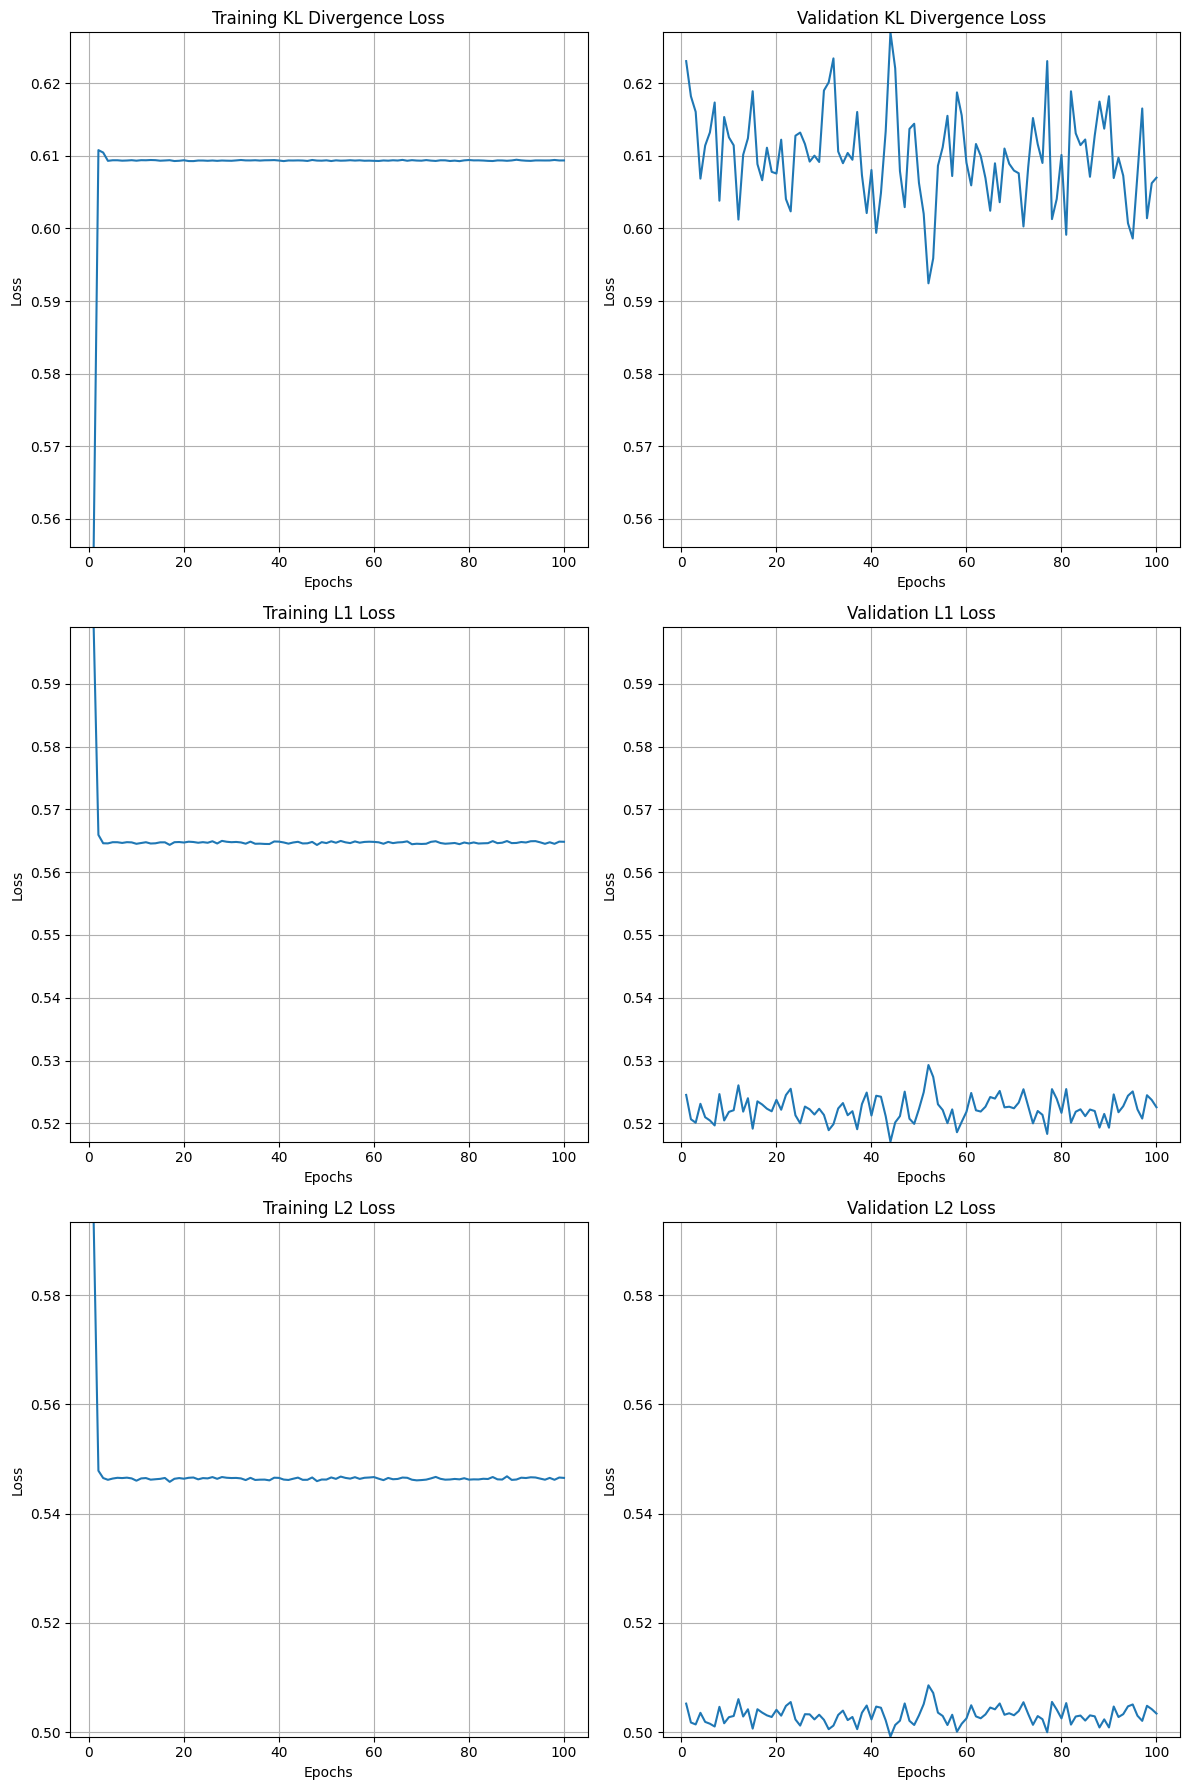

Best Validation Loss in Kelvins:
51.4387 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 17/17 [00:12<00:00,  1.35it/s]


z0: -0.0273
z1: 0.0028
z2: -0.0055
z3: -0.0198


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 717.39it/s]


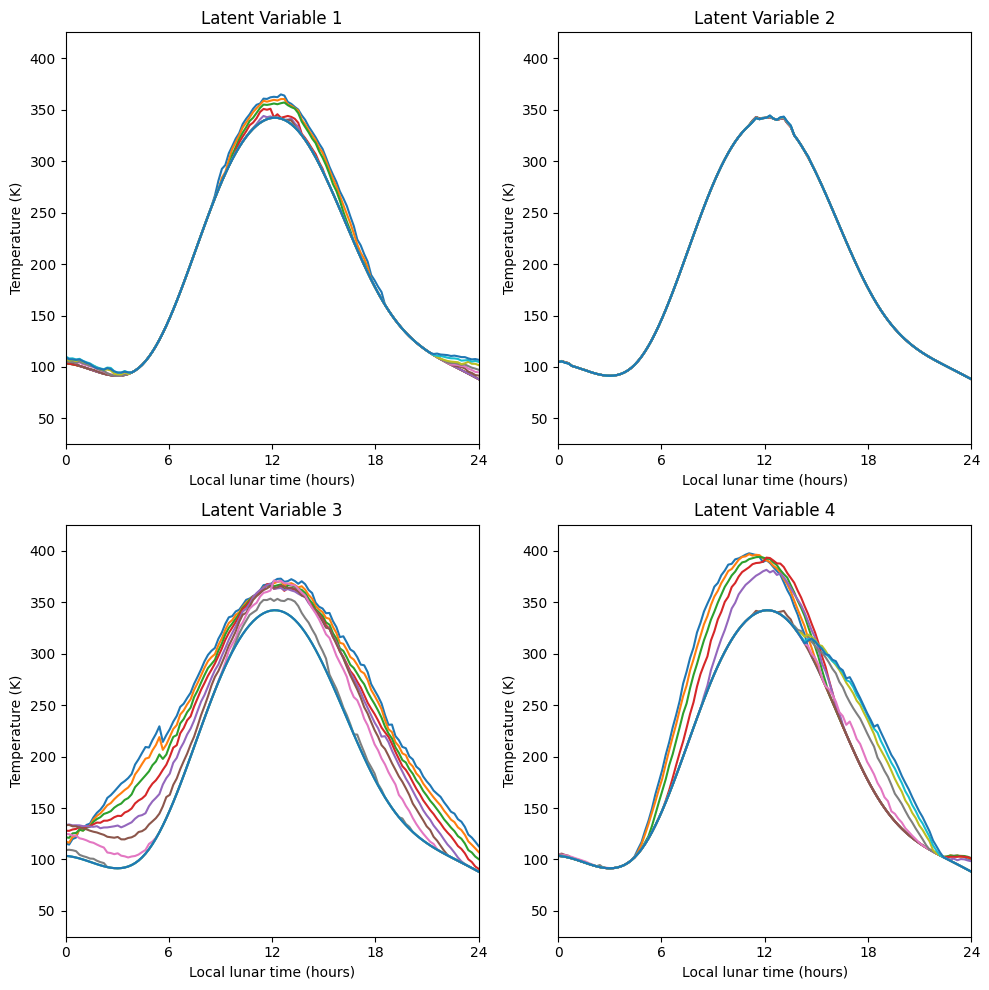

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)